## Introduction

In a previous post, I've shown how to determine the position and orientation of a camera using an ArUco code.

However, when we have multiple ArUco tags, we might want to find the relationships between all of them.

This will require us to work with different coordinate frames and transform coordinates from one frame to another.

I've created a synthetic example, as below. 

It consists of 2 tags, with the ArUco indexes of 0 and 1.

Tag 0 remains untransformed.

Tag 1 has undergone two transformations.

1. Translation by [3, 4, 0].
2. Rotation by 37 degrees around its Z-axis.

The camera itself is located at [5, -14, 10].

![](https://cgcooke.github.io/Blog//images/2021-25-03-Working-with-multiple-coordinate-systems-from-ArUco-tags/header.png)

Let's now detect the ArUco tags in the image and then work out the position and orientation of the camera, according to each of the tag's coordinate systems.

## Extracting ArUco tags

In [1]:
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot

plt.rcParams['figure.figsize'] = [10,10]
np.set_printoptions(precision=2, suppress=True)

Because we generated this image synthetically, we can quickly generate the Intrinsic matrix *K*.
We also know that there is no distortion present.

In [2]:
focal_length_mm = 50
width_pixels = 800.0
height_pixels = 600.0
width_mm = 36.0

pixels_per_mm = width_pixels/width_mm
focal_length_pixels = pixels_per_mm * focal_length_mm


K = np.array([[focal_length_pixels, 0.0 , width_pixels/2],
              [0.0   , focal_length_pixels, height_pixels/2],
              [0.0   , 0.0   ,    1.0]])

dist = np.array([[0.0],[0.0],[0.0],[0.0],[0.0]])

We also know the dimensions of the target. Let's set the origin of the target's coordinate system to be in the centre of the target.

In [3]:
points_3d = np.array([[0.0,1.2,0.0],
                      [1.2,1.2,0.0],
                      [1.2,0.0,0.0],
                      [0.0,0.0,0.0]])

points_3d[:,0:2] -= 0.6

arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
arucoParams = cv2.aruco.DetectorParameters_create()

Now we can detect the tags and visualise their coordinate systems.

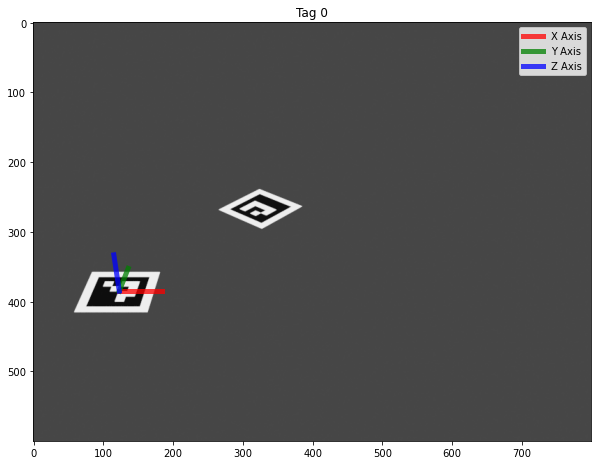

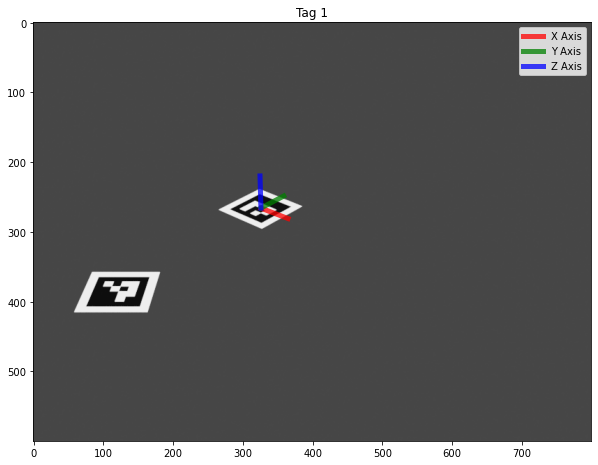

In [15]:
f_str = 'data/2021-03-25-Working-with-multiple-coordinate-systems-from-ArUco-tags/120.png'
img = cv2.imread(f_str)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
(corners, ids, rejected) = cv2.aruco.detectMarkers(gray, arucoDict, parameters=arucoParams)

tags = {}
for i in range(len(corners)):
    tag_id = int(ids[i])
    points_2d = corners[i].squeeze()

    ret, rvec, tvec = cv2.solvePnP(objectPoints = points_3d, imagePoints = points_2d, cameraMatrix = K, distCoeffs = dist, flags = cv2.SOLVEPNP_IPPE_SQUARE)

    r = Rot.from_rotvec(rvec[:,0])
    R = r.as_matrix()
    t = np.array(tvec)

    #Find the camera's center, in the tag's coordinate system.
    C = - np.dot(R.T,tvec)
    
    #Find the rotation of the camera, in the tag's coordinate system.
    R = Rot.from_matrix(R.T).as_matrix()
    
    tags[tag_id] = (R,C)
    
    
    # project 3D points to image plane
    axis = np.float32([[0,0,0],[1,0,0], [0,1,0], [0,0,1]]).reshape(-1,3)
    imgpts, jac = cv2.projectPoints(axis, rvec, tvec, K, dist)
    imgpts = np.squeeze(imgpts)
    
    
    plt.imshow(img[:,:,::-1])
    plt.plot([imgpts[0,0],imgpts[1,0]],[imgpts[0,1], imgpts[1,1]], color='r', alpha=0.75, linewidth=5, label='X Axis')
    plt.plot([imgpts[0,0],imgpts[2,0]],[imgpts[0,1], imgpts[2,1]], color='g', alpha=0.75, linewidth=5, label='Y Axis')
    plt.plot([imgpts[0,0],imgpts[3,0]],[imgpts[0,1], imgpts[3,1]], color='b', alpha=0.75, linewidth=5, label='Z Axis')

    plt.title(f'Tag {tag_id}')
    plt.legend()
    plt.show()

## Changing Coordinate Frames

From the above, we can see two different coordinate systems, one per tag.

Let's take a bird's eye view of the situation:

![](https://cgcooke.github.io/Blog//images/2021-25-03-Working-with-multiple-coordinate-systems-from-ArUco-tags/Top_Down.png)

Previously, we found the rotation and the camera's position in the coordinate frame of each tag.

In [5]:
R_0, C_0 = tags[0]

print(R_0)
print(C_0)

[[ 1.   -0.   -0.  ]
 [ 0.   -0.49  0.87]
 [-0.   -0.87 -0.49]]
[[  4.61]
 [-15.17]
 [ 10.25]]


In [6]:
R_1, C_1 = tags[1]

print(R_1)
print(C_1)

[[ 0.78  0.3  -0.54]
 [ 0.62 -0.37  0.69]
 [ 0.01 -0.88 -0.48]]
[[ 13.2 ]
 [-14.46]
 [ 10.  ]]


![](https://cgcooke.github.io/Blog//images/2021-25-03-Working-with-multiple-coordinate-systems-from-ArUco-tags/Vectors2.png)



Given the information we have, what if we want to find the position and orientation of Tag 1 with respect to Tag 0's coordinate frame?

Working with all of our measurements in a single frame will provide us with a singular, coherent view of our world.

Fortunately, this is relatively easy.

We can first find the relative rotation between the two tags.

In [ ]:
#Rotatation of Tag 1 with respect to Tag 0
R_delta = np.dot(R_0, R_1.T)

Once we have done this, we can transform C_1 into Tag 0's coordinate system and then subtract it from C_0, forming the vector T_1

In [7]:
#Position of the tag with respect to the origin
T_1 = C_0 - np.dot(R_delta,C_1)

array([[ 3.08],
       [ 4.21],
       [-0.02]])

We can see that Tag 1 is located at [3.08, 4.21, -0.02]. In reality, the tag is located at [3, 4, 0]. However, there is some noise inherent in the process.

Tag 1 was also rotated by an angle (37 degrees) around its Z-axis. We can measure this angle as follows:

In [17]:
print(np.degrees(np.arccos(R_delta[1,1])))

38.19945877152531


As before, there is a small error between what we have measured, and reality.

## Conclusion

We can see how we can transform measurements from two different tags, into a single coordinate frame. In another post, I will look at what happens when we have more photos and end up with potentially contradictory measurements due to the measurement noise we will invariably encounter.